# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста. Перед нами стоит задача регрессии, так мы будем прогнозировать непрерывное значение. 

## Исследовательский анализ данных

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
age = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
age.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [4]:
age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
print(f'Количество уникальных значений в каждом столбце:\n{age.nunique()}')

Количество уникальных значений в каждом столбце:
file_name    7591
real_age       97
dtype: int64


In [6]:
print(f"Минимальный возраст: {age['real_age'].min()}")
print(f"Максимальный возраст: {age['real_age'].max()}")
print(f"Средний возраст: {round(age['real_age'].mean(), 3)}")

Минимальный возраст: 1
Максимальный возраст: 100
Средний возраст: 31.201


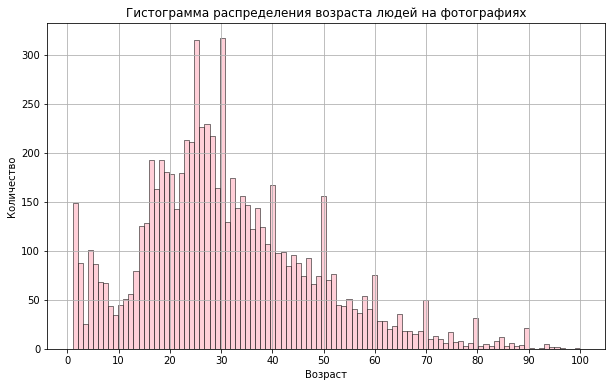

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(age['real_age'], kde=False, bins=100, color='pink')
plt.title('Гистограмма распределения возраста людей на фотографиях')
plt.xlabel('Возраст')
plt.xticks(range(0, int(age['real_age'].max())+1, 10))
plt.grid(True) 
plt.ylabel('Количество')
plt.show()

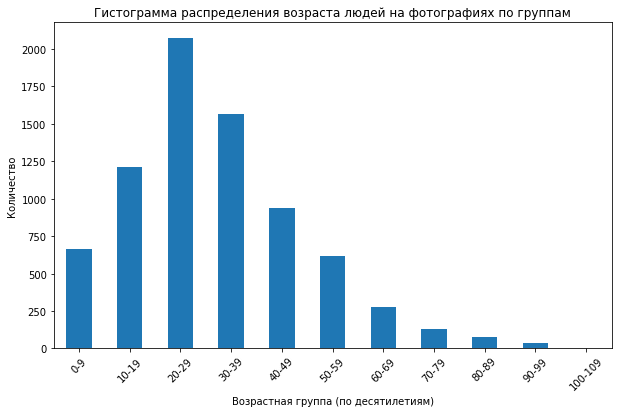

In [8]:
age['decade'] = age['real_age'] // 10 * 10
grouped_years = age.groupby('decade').size()

grouped_years.plot(x='decade', y='count', kind='bar', figsize=(10, 6))
plt.xlabel('Возрастная группа (по десятилетиям)')
plt.ylabel('Количество')
plt.title('Гистограмма распределения возраста людей на фотографиях по группам')
labels = [f'{decade}-{decade + 9}' for decade in grouped_years.index]
plt.xticks(range(len(grouped_years.index)), labels, rotation=45)
plt.show()

In [9]:
age = age.drop(columns='decade')
del grouped_years

In [10]:
folder = '/datasets/faces/final_files'
title = os.listdir(folder)
image_count = 0

In [11]:
len(title)

7591

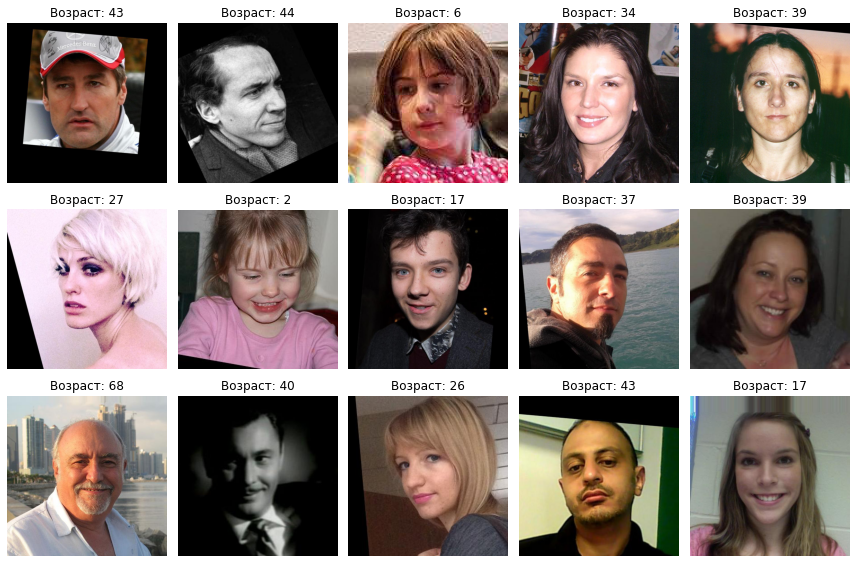

In [12]:
plt.figure(figsize=(12, 8))

for filename in title:
    if image_count >= 15:
        break
    
    image_path = os.path.join(folder, filename)
    image = Image.open(image_path)
    array = np.array(image)
    plt.subplot(3, 5, image_count + 1)
    plt.imshow(array)
    plt.axis('off')
    age_value = age.loc[age['file_name'] == filename, 'real_age'].values[0]
    plt.title(f'Возраст: {age_value}')
    image_count += 1

plt.tight_layout()
plt.show()

**Вывод:**

Датасет содержит 7591 фотографию. В выборке находятся фотографии людей возрастом от 1 до 100 лет, средний возраст - 31,2 года. Наиболее широко представлена возрастная группа 20-39 лет, фотографий людей старше 60 лет в датасете относительно мало. Несбалансированное распределение возрастов может привести к тому, что модель будет хуже предсказывать возраст людей из менее представленных возрастных групп. На гистограмме заметны пики на круглых значениях возраста - это может быть обусловлено спецификой сбора данных (системаитическим округлением до ближайшего десятка) или демографическими особенностями (маловероятно).

Размер изображений отличается, как и количество слоев в них: встречаются и черно-белые, и цветные фото. Перед обучением модели необходимо будет нормализовать пиксельные значения изображений и привести их к единому формату (224х224 пикселя). На некоторых фотографиях присутствуют черные участки, что говорит о том, что изображения были повернуты или обрезаны, также, возможно, некторые фотографии были сделаны в формате, не соответствующем стандартному соотношению сторон, и при подгонке под другой размер, появились пустые полосы черного цвета по краям изображения. 

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        validation_split=0.25, 
        rescale=1.0/255.0) 
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'), 
        directory=path + 'final_files/', 
        x_col = 'file_name',
        y_col = 'real_age',
        target_size=(224, 224),  
        batch_size=32, 
        class_mode='other',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1.0/255.0)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'), 
        directory=path + 'final_files/', 
        x_col = 'file_name',
        y_col = 'real_age',
        target_size=(224, 224),  
        batch_size=32, 
        class_mode='other',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model 

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model 

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 68s - loss: 189.7878 - mean_absolute_error: 10.1125 - val_loss: 642.9661 - val_mean_absolute_error: 20.3753
Epoch 2/10
178/178 - 41s - loss: 94.9946 - mean_absolute_error: 7.3832 - val_loss: 718.5182 - val_mean_absolute_error: 21.8346
Epoch 3/10
178/178 - 41s - loss: 71.8244 - mean_absolute_error: 6.4900 - val_loss: 545.8357 - val_mean_absolute_error: 18.1538
Epoch 4/10
178/178 - 39s - loss: 53.8935 - mean_absolute_error: 5.5849 - val_loss: 151.4424 - val_mean_absolute_error: 9.2749
Epoch 5/10
178/178 - 39s - loss: 40.1286 - mean_absolute_error: 4.8386 - val_loss: 128.9194 - val_mean_absolute_error: 8.6602
Epoch 6/10
178/178 - 38s - loss: 33.1226 - mean_absolute_error: 4.4059 - val_loss: 83.3691 - val_mean_absolute_error: 6.8064
Epoch 7/10
178/178 - 38s - loss: 29.5540 - mean_absolute_error: 4.1274 - val_loss: 78.4960 - val_mean_absolute_error: 6.6310
Epoch 8/10
178/178 - 38s - loss: 24.3687 - mean_absolute_error: 3.8065 - val_loss: 103.9613 - val_mean_absolute_error: 8.0179
Epoch 9/10
178/178 - 38s - loss: 19.9040 - mean_absolute_error: 3.4258 - val_loss: 70.5782 - val_mean_absolute_error: 6.3480
Epoch 10/10
178/178 - 38s - loss: 16.6228 - mean_absolute_error: 3.1540 - val_loss: 72.7026 - val_mean_absolute_error: 6.4664

60/60 - 10s - loss: 72.7026 - mean_absolute_error: 6.4664
Test MAE: 6.4664

```

## Анализ обученной модели

Модель успешно достигла целевого показателя MAE меньше 7. Значение полученной метрики MAE означает, что в среднем модель ошибается на 6.46 года при предсказании возраста человека по фотографии. Снижение как Loss (MSE), так и MAE на тренировочной и валидационной выборках указывает на хорошее обучение модели. Модель смогла быстро адаптироваться к данным и выучить релевантные признаки для предсказания возраста. Такого резульата удалось достичь использованием архитектуры ResNet50 с дополнительными слоями GlobalAveragePooling2D и Dense, а также оптимизатора Adam с начальной скоростью обучения 0.0003. К набору данных был применен метод аугментации Flip c целью уведичения разнообразия данных - были созданы зеркальные отображения фотографий путем их отражения по горизонтали без именения их содержания. Есть некоторые признаки переобучения модели: об этом говорит разница между MAE на тренировочной (3,15) и валидационной (6,46) выборках, возможно, использование инструментов регуляризации помогло бы добиться лучших результатов метрики на тестовых данных. Увеличение количества эпох также может улучшить обобщающую способность модели, сейчас модель обучалась на 10 эпохах. Несбалансированный характер данных - небольшое количество людей старше 60 лет в наборе - также мог ухудшить качество модели.